# 75.06/95.58 Organización de Datos
# Primer Cuatrimestre de 2020
# Trabajo Práctico 2: Enunciado


El segundo TP es una competencia de Machine Learning en donde cada grupo debe intentar determinar, para cada tweet brindado, si el mismo esta basado en un hecho real o no.

La competencia se desarrolla en la plataforma de Kaggle  https://www.kaggle.com/c/nlp-getting-started.  

El dataset consta de una serie de tweets, para los cuales se informa:

- id - identificador unico para cada  tweet
- text - el texto del tweet
- location - ubicación desde donde fue enviado (podría no estar)
- keyword - un keyword para el tweet  (podría faltar)
- target - en train.csv, indica si se trata de un desastre real  (1) o no (0)
 


Los submits con el resultado deben tener el formato:

Id: Un id numérico para identificar el tweet
target: 1 / 0 según se crea que el tweet se trata sobre un desastre real, o no.

Los grupos deberán probar distintos algoritmos de Machine Learning para intentar predecir si el tweet está basado en hechos reales o no. A medida que los grupos realicen pruebas deben realizar el correspondiente submit en Kaggle para evaluar el resultado de los mismos.

Al finalizar la competencia el grupo que mejor resultado tenga obtendrá 10 puntos para cada uno de sus integrantes que podrán ser usados en el examen por promoción o segundo recuperatorio.

## Requisitos para la entrega del TP2:

- El TP debe programarse en Python o R.
- Debe entregarse un pdf con el informe de algoritmos probados, algoritmo final utilizado, transformaciones realizadas a los datos, feature engineering, etc. 
- El informe debe incluir también un link a github con el informe presentado en pdf, y todo el código.
- El grupo debe presentar el TP en una computadora en la fecha indicada por la cátedra, el TP debe correr en un lapso de tiempo razonable (inferior a 1 hora) y generar un submission válido que iguale el mejor resultado obtenido por el grupo en Kaggle. (mas detalles a definir)

## El TP2 se va a evaluar en función del siguiente criterio:

- Cantidad de trabajo (esfuerzo) del grupo: ¿Probaron muchos algoritmos? ¿Hicieron un buen trabajo de pre-procesamiento de los datos y feature engineering?
- Resultado obtenido en Kaggle (obviamente cuanto mejor resultado mejor nota)
- Presentación final del informe, calidad de la redacción, uso de información obtenida en el TP1, conclusiones presentadas.
- Performance de la solución final.

## Forma de evaluar kaggle

Las presentaciones se evalúan utilizando F1 entre las respuestas previstas y esperadas.

F1 se calcula de la siguiente manera:
$ F1=(2∗precision∗recall)/(precision+recall) $

donde:

$precision=TP/(TP+FP)$

$recall=TP/(TP+FN)$


con:

- Verdadero positivo [TP] = your prediction is 1, and the ground truth is also 1 - you predicted a positive and that's true!
- Falso positivo [FP] = your prediction is 1, and the ground truth is 0 - you predicted a positive, and that's false.
- Falso Negativo [FN] = your prediction is 0, and the ground truth is 1 - you predicted a negative, and that's false.

importaciones

In [28]:
#IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.graph_objects as go

#plt.style.use('default')
from gensim.sklearn_api import tfidf

sns.set(style="whitegrid")

pd.options.display.float_format = '{:20,.2f}'.format 

import warnings
warnings.filterwarnings('ignore')

import os
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import re
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
import math
#librerias para KNN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
#red neuronal
from keras.models import Sequential
from keras.layers.core import Dense
#arboles de decicion
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
#catboost
from catboost import CatBoostRegressor
#xgb
import xgboost as xgb

#palabras
import nltk
#nltk.download('stopwords')#si no tiene stopword habilitar esta linea
from nltk.corpus import stopwords
import gensim 
from gensim.models import Word2Vec 
#tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
stopwordEnglis = stopwords.words('english')
#tfidf = TfidfVectorizer()

inicio de csv

In [101]:
tweets_original_entrenamiento = pd.read_csv('train.csv',index_col=['id'])
tweets_original_entrenamiento.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [102]:
tweets_original_prueba = pd.read_csv('test.csv',index_col=['id'])
tweets_original_prueba.head()

,keyword,location,text
id,,,
0,NaN,NaN,Just happened a terrible car crash
2,NaN,NaN,"Heard about #earthquake is different cities, s..."
3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


calculo resultado

In [103]:
#resultados
resultados_de_test = pd.read_csv('respuestas.csv',index_col=['id'])
#revisar los resultados
def calclarPresicionYRecall(df):
    respuestas = pd.read_csv('respuestas.csv',index_col=['id'])
    respuestas['prediccion'] = df['target']
    #respuestas['TP'] = [1 if (respuestas['target'] == 1 and respuestas['prediccion'] == 1) else 0]
    #respuestas['FP'] = [1 if (respuestas['target'] == 0 and respuestas['prediccion'] == 1) else 0]
    #respuestas['FN'] = [1 if (respuestas['target'] == 1 and respuestas['prediccion'] == 0) else 0]
    
    respuestas.loc[respuestas['prediccion'] + respuestas['target'] == 2 , 'TP'] = 1
    respuestas.loc[respuestas['prediccion'] + (respuestas['target'] * 2) == 1 , 'FP'] = 1
    respuestas.loc[respuestas['prediccion'] + (respuestas['target'] * 2) == 2 , 'FN'] = 1
    respuestas['TP'].fillna(0, inplace=True)
    respuestas['FP'].fillna(0, inplace=True)
    respuestas['FN'].fillna(0, inplace=True)

    tp = respuestas['TP'].sum()
    fp = respuestas['FP'].sum()
    fn = respuestas['FN'].sum()
    
    #print(tp,fp,fn)
    #print(respuestas.head())
    
    sumaPresicion = tp + fp
    sumaRecall = tp + fn
    presicion = tp / sumaPresicion
    recall = tp / sumaRecall
    return (presicion,recall)

def F1(df):
    presicion,recall = calclarPresicionYRecall(df)
    resultado = 2 * presicion * recall
    resultado /= (presicion + recall)
    return resultado

inicio de problema

## CATBOOST

In [104]:
#esto deberia ahorrar columnas al hacer un BOW
def digitos_en_binario(numero):
    logaritmo2 = math.log2(numero)
    entero = int(logaritmo2)
    entero += 1
    return entero

def transformar_a_vector_binario(numero,digitos):
    nBinario = aBinario(numero)
    digit = len(nBinario)
    while (digit < digitos):
        digit = len(nBinario)
        nBinario.insert(0,0)
    return nBinario

def aBinario(numero):
    numeroDecimal = numero
    numeroBinario = []
    if (numeroDecimal < 2):
        numeroBinario.append(numeroDecimal)
        return numeroBinario
    while numeroDecimal >=2:
        numeroBinario.append(numeroDecimal % 2)
        numeroDecimal //= 2
    numeroBinario.append(numeroDecimal)
    numeroBinario.reverse()
    return numeroBinario

#PRUEVA
#if (digitos_en_binario(63) != 6):
#    print("error en digitos_en_binario")
#bina = aBinario(64)
#if (bina != 6 and bina[0] != 1 and bina[1] != 0 and bina[2] != 0 and bina[3] != 0 and bina[4] != 0 and bina[5] != 0):
#    print("error en aBinario")
#print(transformar_a_vector_binario(64,8))
#TODO OK

In [105]:
"""
vacio = 0000
a = 0001
b = 0010
c = 0011
d = 0100
e = 0101
f = 0110
h = 0111
r = 1000
s = 1001
t = 1010
w = 1011
"""
LETRAS_0 = ['a','c','e','h','s','w']
def letra0(x):
    if (x in LETRAS_0):
        return 1
    return 0
LETRAS_1 = ['b','c','f','h','t','w']
def letra1(x):
    if (x in LETRAS_1):
        return 1
    return 0
LETRAS_2 = ['d','e','f','h']
def letra2(x):
    if (x in LETRAS_2):
        return 1
    return 0
LETRAS_3 = ['r','s','t','w']
def letra3(x):
    if (x in LETRAS_3):
        return 1
    return 0
def letra_inicial_Keyword_BOW(df):
    #for i in range(0,4):
    #    texto = 'letra_' + str(i)
    #    df[texto] = 0
    df['letra_0'] = 0
    df['letra_1'] = 0
    df['letra_2'] = 0
    df['letra_3'] = 0
    df['letra_0'] = df['keyword'].str.strip().str[0].map(lambda x:letra0(x))
    df['letra_1'] = df['keyword'].str.strip().str[0].map(lambda x:letra0(x))
    df['letra_2'] = df['keyword'].str.strip().str[0].map(lambda x:letra0(x))
    df['letra_3'] = df['keyword'].str.strip().str[0].map(lambda x:letra0(x))
    return df
     

In [106]:

def set_palabras_del_train(df):
    palabrasTexto = []
    palabrasKeyword = []
    
    df['palabras_de_texto'] = df['text'].str.lower().str.split().apply(lambda x: [item for item in x if item not in stopwordEnglis])
    df['palabras_de_keyword'] = df['text'].str.lower().str.split().apply(lambda x: [item for item in x if item not in stopwordEnglis])
    
    return (palabrasTexto,palabrasKeyword)

def hashtag_en_tweet(listado):
    """defino hashtag como un numeral seguido por una cadena de texto"""
    contador = 0
    for palabra in listado:
        if (palabra[0] == '#'):
            contador += 1
    return contador

def str_hashtag_en_tweet(listado):
    """defino hashtag como un numeral seguido por una cadena de texto"""
    for palabra in listado:
        if (palabra[0] == '#'):
            return palabra
    return ""

def cantidad_de_palabras_en_texto(lista,palabra):
    contador = 0
    for elemento in lista:
        if (elemento == palabra):
            contador += 1
    return contador

def localizacion(x,lista):
    if (x == ""):
        return 0
    for i in range(len(lista)):
        palabra = lista[i]
        if (palabra == x):
            return (i + 1)
    return 0

def ubicacionEnLista(x,pos):
    return x[pos]

def BOW_locacion(df,lista,columna):
    cantidadDePalabras = len(lista)
    if (cantidadDePalabras == 0):
        return df
    binarioMaximo = cantidadDePalabras + 1
    digitosBinario = digitos_en_binario(binarioMaximo)
    #for i in range(digitosBinario):
    #    df["palabra_{}".format(i)] = 0
    #df['location'] = df['location'].map(lambda x: transformar_a_vector_binario(localizacion(x,lista),digitosBinario))
    #for j in range(digitosBinario):
    #    df["loc_palabra_{}".format(j)] = df['location'].map(lambda x: ubicacionEnLista(x,j))
    df[columna] = df[columna].map(lambda x: transformar_a_vector_binario(localizacion(x,lista),digitosBinario))
    for j in range(digitosBinario):
        df["{}_palabra_{}".format(columna,j)] = df[columna].map(lambda x: ubicacionEnLista(x,j))
    return df

In [107]:
def preparar_df(df,listadoDePalabrasDelTextoDelSetDeEntrenamiento=[],listadoDePalabrasDeLocalizacionesDelSetDeEntrenamiento=[],listadoDePalabrasDelKeywordDelSetDeEntrenamiento=[]):
    df['text'].fillna("", inplace=True)
    df['keyword'].fillna("", inplace=True)
    df['location'].fillna("", inplace=True)
    
    df['longitud_de_texto'] = df['text'].str.len()
    df['longitud_de_keyword'] = df['keyword'].str.len()
    
    df['palabras_de_texto'] = df['text'].str.lower().str.split().apply(lambda x: [item for item in x if item not in stopwordEnglis])
    df['palabras_de_keyword'] = df['keyword'].str.lower().str.split().apply(lambda x: [item for item in x if item not in stopwordEnglis])
    
    df['cantidad_de_palabras_texto'] = df['palabras_de_texto'].map(len)
    df['cantidad_de_palabras_keyword'] = df['palabras_de_keyword'].map(len)
    
    df['cantidad_de_hashtag_en_texto'] = df['palabras_de_texto'].map(hashtag_en_tweet)
    
    df['palabras_de_texto'] = df['palabras_de_texto'].apply(lambda x: [item for item in x if item in listadoDePalabrasDelTextoDelSetDeEntrenamiento])
    #df['palabras_de_keyword'] = df['palabras_de_keyword'].apply(lambda x: [item for item in x if item in listadoDePalabrasDelKeywordDelSetDeEntrenamiento])
    
    #Se requiere pensarlo mas
    #cantidadDePalabrasDelTexto = len(listadoDePalabrasDelTextoDelSetDeEntrenamiento)
    #for i in range(cantidadDePalabrasDelTexto):
    #    df["palabra_{}".format(i)] = 0
    
    df = letra_inicial_Keyword_BOW(df)
    
    #for palabra in listadoDePalabrasDelTextoDelSetDeEntrenamiento:
    #    df[palabra] = df['palabras_de_texto'].map(lambda x: cantidad_de_palabras_en_texto(x,palabra))
    
    df = BOW_locacion(df,listadoDePalabrasDeLocalizacionesDelSetDeEntrenamiento,'location')
    df = BOW_locacion(df,listadoDePalabrasDelKeywordDelSetDeEntrenamiento,'keyword')
    #hashtag
    df['hashtag_en_texto'] = df['palabras_de_texto'].map(str_hashtag_en_tweet)
    df = BOW_locacion(df,listadoDePalabrasDelTextoDelSetDeEntrenamiento,'hashtag_en_texto')
    df = df.drop(columns=['hashtag_en_texto'])
    
    #df['text'] = df['text'].str.replace(r' ', '')
    #df['keyword'] = df['keyword'].str.replace(r' ', '')
    #df['location'] = df['location'].str.replace(r' ', '')
    
    #TF-IDF
    #x = TfidfVectorizer.fit_transform(df['palabras_de_texto'])
    #df_tfidf = pd.DataFrame(x.toarray(), columns=tfidf.get_feature_names())
    #for col in df_tfidf.columns():
    #    df = df.join(df_tfidf[col])
    #df.join(df_tfidf)#mal planteado
    
    df = df.drop(columns=['keyword','text','location'])
    df = df.drop(columns=['palabras_de_texto','palabras_de_keyword'])
    
    return df

In [108]:
def extraer_palabras(serie):
    lista = []
    #dic = {}
    for listado in serie:
        for elemento in listado:
            #la mayoria de las palabras en ingles tienen una esperansa de 4.8773 caracteres con varianza de 2.6171
            longitud = len(elemento)
            simbolos = ('0','1','2','3','4','5','6','7','8','9','#','/','','"','@',';','?','[','(','{','.','!','$','&','*','-')
            #if (elemento in lista or longitud > 7 or longitud < 2 or elemento[0] in simbolos or elemento[-1] in simbolos):
            if (elemento in lista or elemento[0] != '#'):
                #dic[elemento] += 1
                continue
            #dic[elemento] = 1
            lista.append(elemento)
    #resultado = []
    #max = 0
    #for palabra in lista:
    #    max = dic[palabra]
    #    if (dic[palabra] < 800):
    #        continue
    #    resultado.append(palabra)
    return lista

def generar_lista(x,lista):
    if (x in lista or x == ""):
        return
    lista.append(x)
    return

In [109]:
train_label = tweets_original_entrenamiento['target']
train_set = tweets_original_entrenamiento
train_set = train_set.drop(columns=['target'])

In [110]:
train_set['location'].fillna("", inplace=True)
train_set['text'].fillna("", inplace=True)

seriePalabrasTexto = train_set['text'].str.lower().str.split().apply(lambda x: [item for item in x if item not in stopwordEnglis])
seriePalabrasLocation = []
train_set['location'].str.lower().apply(lambda x: generar_lista(x,seriePalabrasLocation))
seriePalabrasKeyword = []
train_set['keyword'].str.lower().apply(lambda x: generar_lista(x,seriePalabrasKeyword))
seriePalabrasKeyword = []
train_set['keyword'].str.lower().apply(lambda x: generar_lista(x,seriePalabrasKeyword))

listadoDePalabrasDelTextoDelSetDeEntrenamiento = extraer_palabras(seriePalabrasTexto)
#listadoDePalabrasDelTextoDelSetDeEntrenamiento = []#prueva de valor de palabras
listadoDePalabrasDeLocalizacionesDelSetDeEntrenamiento = seriePalabrasLocation
listadoDePalabrasDelKeywordDelSetDeEntrenamiento = seriePalabrasKeyword

In [111]:
train_set = preparar_df(train_set,listadoDePalabrasDelTextoDelSetDeEntrenamiento,listadoDePalabrasDeLocalizacionesDelSetDeEntrenamiento,listadoDePalabrasDelKeywordDelSetDeEntrenamiento)
train_set.head()

,longitud_de_texto,longitud_de_keyword,cantidad_de_palabras_texto,cantidad_de_palabras_keyword,cantidad_de_hashtag_en_texto,letra_0,letra_1,letra_2,letra_3,location_palabra_0,...,hashtag_en_texto_palabra_1,hashtag_en_texto_palabra_2,hashtag_en_texto_palabra_3,hashtag_en_texto_palabra_4,hashtag_en_texto_palabra_5,hashtag_en_texto_palabra_6,hashtag_en_texto_palabra_7,hashtag_en_texto_palabra_8,hashtag_en_texto_palabra_9,hashtag_en_texto_palabra_10
id,,,,,,,,,,,,,,,,,,,,,
1,69,0,7,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,38,0,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,133,0,11,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,65,0,7,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,88,0,9,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [112]:
test_set = tweets_original_prueba
test_set = preparar_df(test_set,listadoDePalabrasDelTextoDelSetDeEntrenamiento,listadoDePalabrasDeLocalizacionesDelSetDeEntrenamiento,listadoDePalabrasDelKeywordDelSetDeEntrenamiento)
test_set.head()

,longitud_de_texto,longitud_de_keyword,cantidad_de_palabras_texto,cantidad_de_palabras_keyword,cantidad_de_hashtag_en_texto,letra_0,letra_1,letra_2,letra_3,location_palabra_0,...,hashtag_en_texto_palabra_1,hashtag_en_texto_palabra_2,hashtag_en_texto_palabra_3,hashtag_en_texto_palabra_4,hashtag_en_texto_palabra_5,hashtag_en_texto_palabra_6,hashtag_en_texto_palabra_7,hashtag_en_texto_palabra_8,hashtag_en_texto_palabra_9,hashtag_en_texto_palabra_10
id,,,,,,,,,,,,,,,,,,,,,
0,34,0,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,64,0,7,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,96,0,10,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,40,0,4,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11,45,0,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [113]:
print(test_set['cantidad_de_palabras_keyword'].max())
print(train_set['cantidad_de_palabras_keyword'].max())

1
1


In [97]:
for n in test_set.columns:
    try:
        #test_set[n] = pd.to_numeric(test_set[n])
        test_set[n].astype(int)
    except:
        print(n)
for n in train_set.columns:
    try:
        #train_set[n] = pd.to_numeric(train_set[n])
        train_set[n].astype(int)
    except:
        print(n)
if (len(test_set.columns) != len(train_set.columns)):
    print("Error en columnas")

In [96]:
train_set.head()

,longitud_de_texto,longitud_de_keyword,cantidad_de_palabras_texto,cantidad_de_palabras_keyword,cantidad_de_hashtag_en_texto,letra_0,letra_1,letra_2,letra_3,deeds,...,location_palabra_10,location_palabra_11,keyword_palabra_0,keyword_palabra_1,keyword_palabra_2,keyword_palabra_3,keyword_palabra_4,keyword_palabra_5,keyword_palabra_6,keyword_palabra_7
id,,,,,,,,,,,,,,,,,,,,,
1,69,0,7,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,38,0,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,133,0,11,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,65,0,7,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,88,0,9,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [114]:
def ensamble(df,n,prediccion):
    #df['prediccion'] = prediccion
    #df['prediccion'] = df['prediccion'].round()
    df['target'] = df['target'] + prediccion.round()
    n += 1
    return (n,df)

def calcular_resultado_de_prediccion(df,n):
    df['target'] = df['target'].div(n).round()
    return df

In [89]:
resultados_de_prediccion = pd.read_csv('sample_submission.csv',index_col=['id'])
cantidadDePredicciones = 0
#catboost
######verificacion de hiperparamentros
hiperparametros_max = [0,0,0]
res_max = 0
contador = 0
for iter in range(4,8,1):
    for lR in range(65,76,1):
        learningRate = lR / 100
        for profundidad in range(11,14):
            # Initialize CatBoostRegressor
            model = CatBoostRegressor(iterations=iter,
                                      learning_rate=learningRate,
                                      depth=profundidad)
            # Fit model
            model.fit(train_set, train_label)
            # Get predictions
            predicion = model.predict(test_set)
            #cantidadDePredicciones,resultados_de_prediccion = ensamble(resultados_de_prediccion,cantidadDePredicciones,predicion)
            #print("prediccion = ",cantidadDePredicciones)
            
            ######verificacion de hiperparamentros
            df = pd.DataFrame()
            cantidadDePredicciones,resultados_de_prediccion = ensamble(resultados_de_prediccion,cantidadDePredicciones,predicion)
            maximo_local = F1(resultados_de_prediccion)
            if (maximo_local <= 0.53):
                contador += 1
            if(maximo_local > res_max):
                hiperparametros_max = [iter,learningRate,profundidad]
                res_max = maximo_local
            print("local {} max {}".format(maximo_local,res_max))
            print("local {} max {}".format([iter,learningRate,profundidad],hiperparametros_max))
            resultados_de_prediccion = pd.read_csv('sample_submission.csv',index_col=['id'])
            cantidadDePredicciones = 0
print("contador = {}".format(contador))
print(hiperparametros_max)
print(res_max)

0:	learn: 0.4735122	total: 335ms	remaining: 1s
1:	learn: 0.4633167	total: 685ms	remaining: 685ms
2:	learn: 0.4563104	total: 1.09s	remaining: 364ms
3:	learn: 0.4500376	total: 1.46s	remaining: 0us
local 0.5206208425720621 max 0.5206208425720621
local [4, 0.65, 11] max [4, 0.65, 11]
0:	learn: 0.4722061	total: 731ms	remaining: 2.19s
1:	learn: 0.4606917	total: 1.48s	remaining: 1.48s
2:	learn: 0.4540324	total: 2.44s	remaining: 814ms
3:	learn: 0.4471099	total: 3.21s	remaining: 0us
local 0.5104022191400832 max 0.5206208425720621
local [4, 0.65, 12] max [4, 0.65, 11]
0:	learn: 0.4722077	total: 1.34s	remaining: 4.02s
1:	learn: 0.4623248	total: 2.78s	remaining: 2.78s
2:	learn: 0.4534854	total: 4.32s	remaining: 1.44s
3:	learn: 0.4481993	total: 5.78s	remaining: 0us
local 0.5070422535211268 max 0.5206208425720621
local [4, 0.65, 13] max [4, 0.65, 11]
0:	learn: 0.4733306	total: 402ms	remaining: 1.21s
1:	learn: 0.4631034	total: 752ms	remaining: 752ms
2:	learn: 0.4558911	total: 1.13s	remaining: 376ms
3

In [115]:
resultados_de_prediccion = pd.read_csv('sample_submission.csv',index_col=['id'])
# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=7,
                          learning_rate=0.66,
                          depth=12)
# Fit model
model.fit(train_set, train_label)
# Get predictions
predicion = model.predict(test_set)
cantidadDePredicciones,resultados_de_prediccion = ensamble(resultados_de_prediccion,0,predicion)

0:	learn: 0.4325882	total: 88ms	remaining: 528ms
1:	learn: 0.4151360	total: 172ms	remaining: 431ms
2:	learn: 0.3919730	total: 321ms	remaining: 428ms
3:	learn: 0.3856291	total: 422ms	remaining: 316ms
4:	learn: 0.3765030	total: 514ms	remaining: 206ms
5:	learn: 0.3688082	total: 634ms	remaining: 106ms
6:	learn: 0.3648540	total: 789ms	remaining: 0us


In [116]:
resultados_de_prediccion = calcular_resultado_de_prediccion(resultados_de_prediccion,cantidadDePredicciones)
print(cantidadDePredicciones)
resultados_de_prediccion

1


,target
id,
0,0.00
2,1.00
3,1.00
9,0.00
11,1.00
...,...
10861,1.00
10865,1.00
10868,1.00


In [117]:
print(F1(resultados_de_prediccion))


0.630841121495327


In [82]:
#para arbol verificar si esta balanceado o no
tweets_entrenamiento = tweets_original_entrenamiento
tweets_entrenamiento.groupby(["target"]).size()

target
0    4342
1    3271
dtype: int64

# XGBoost

In [118]:
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
def eliminarErrorDeValores(df):
    df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df.columns.values]
    return df

In [119]:
test_set = eliminarErrorDeValores(test_set)
train_set = eliminarErrorDeValores(train_set)

In [121]:
######verificacion de hiperparamentros
hiperparametros_max = [0,0,0,0]
res_max = 0
contador = 0
hiperparametros_max
for profundidad in range(6,8,1):
    for tree in range(40,81,20):
        colsampleTree = tree / 100
        for lR in range(10,81,20):
            learningRate = lR / 100
            for alpha in range(5,16,5):
                xgb_reg = xgb.XGBRegressor(max_depth = profundidad, 
                                           colsample_bytree = colsampleTree, 
                                           learning_rate = learningRate, 
                                           alpha = alpha,
                                           objetive = 'reg:squarederror')
                
                xgb_reg.fit(train_set, train_label)
                result = pd.read_csv('sample_submission.csv')
                predicts = xgb_reg.predict(test_set).round()
                result['target'] = predicts
                
                maximo_local = F1(result)
                if (maximo_local <= 0.528):
                    contador += 1
                if(maximo_local > res_max):
                    hiperparametros_max = [iter,learningRate,profundidad]
                    res_max = maximo_local
                print("local {} max {}".format(maximo_local,res_max))
print("contador = {}".format(contador))
print(hiperparametros_max)
print(res_max)

[23:52:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { objetive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


local 0.3649851632047478 max 0.3649851632047478
[23:53:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { objetive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


local 0.363103953147877 max 0.3649851632047478
[23:54:26] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { objetive } might 

In [120]:
xgb_reg = xgb.XGBRegressor(max_depth = 7, 
                           colsample_bytree = 0.5, 
                           learning_rate = 0.6, 
                           alpha = 10,
                           objetive = 'reg:squarederror')

In [121]:
xgb_reg.fit(train_set, train_label)

[20:29:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { objetive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.6, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objetive='reg:squarederror', random_state=0, reg_alpha=10,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [122]:
result = pd.read_csv('sample_submission.csv',index_col=['id'])

In [123]:
predicts = xgb_reg.predict(test_set).round()
result['target'] = predicts
print(F1(result))

0.6392623895505187


Con K-FOLDS

In [71]:
dmatrix = xgb.DMatrix(data=train_set,label=train_label)
params = {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10,
                    metrics="rmse", as_pandas=True, seed=123)
#ultimo error
print((cv_results["test-rmse-mean"]).tail(1))


49                   0.47
Name: test-rmse-mean, dtype: float64


In [72]:

os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'

xg_reg = xgb.train(params=params, dtrain=dmatrix, num_boost_round=10)
plt.rcParams['figure.figsize'] = [20, 20]
xgb.to_graphviz(xg_reg,num_trees=0)

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

Importancia de cada feature

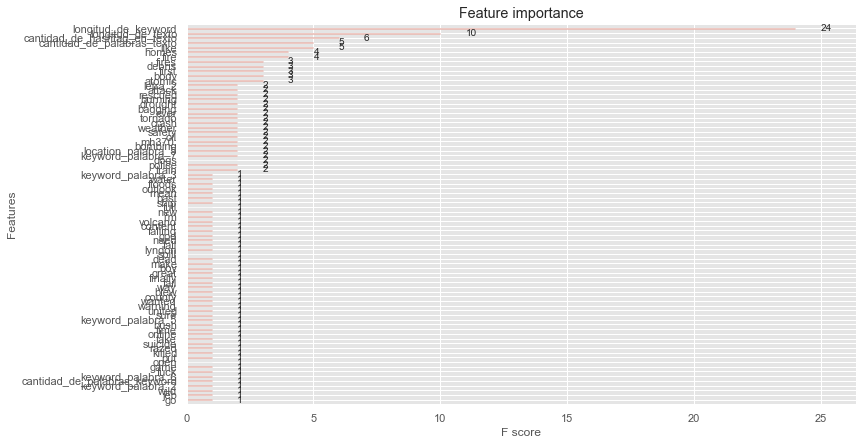

In [21]:
plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(xg_reg)

# Random Forest

In [124]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=1, n_estimators = 20, max_features = 4)
rf.fit(train_set, train_label)

RandomForestRegressor(max_features=4, n_estimators=20, random_state=1)

In [125]:
result = pd.read_csv('sample_submission.csv',index_col=['id'])
predicts = rf.predict(test_set).round()
result['target'] = predicts
print(F1(result))

0.6297709923664122


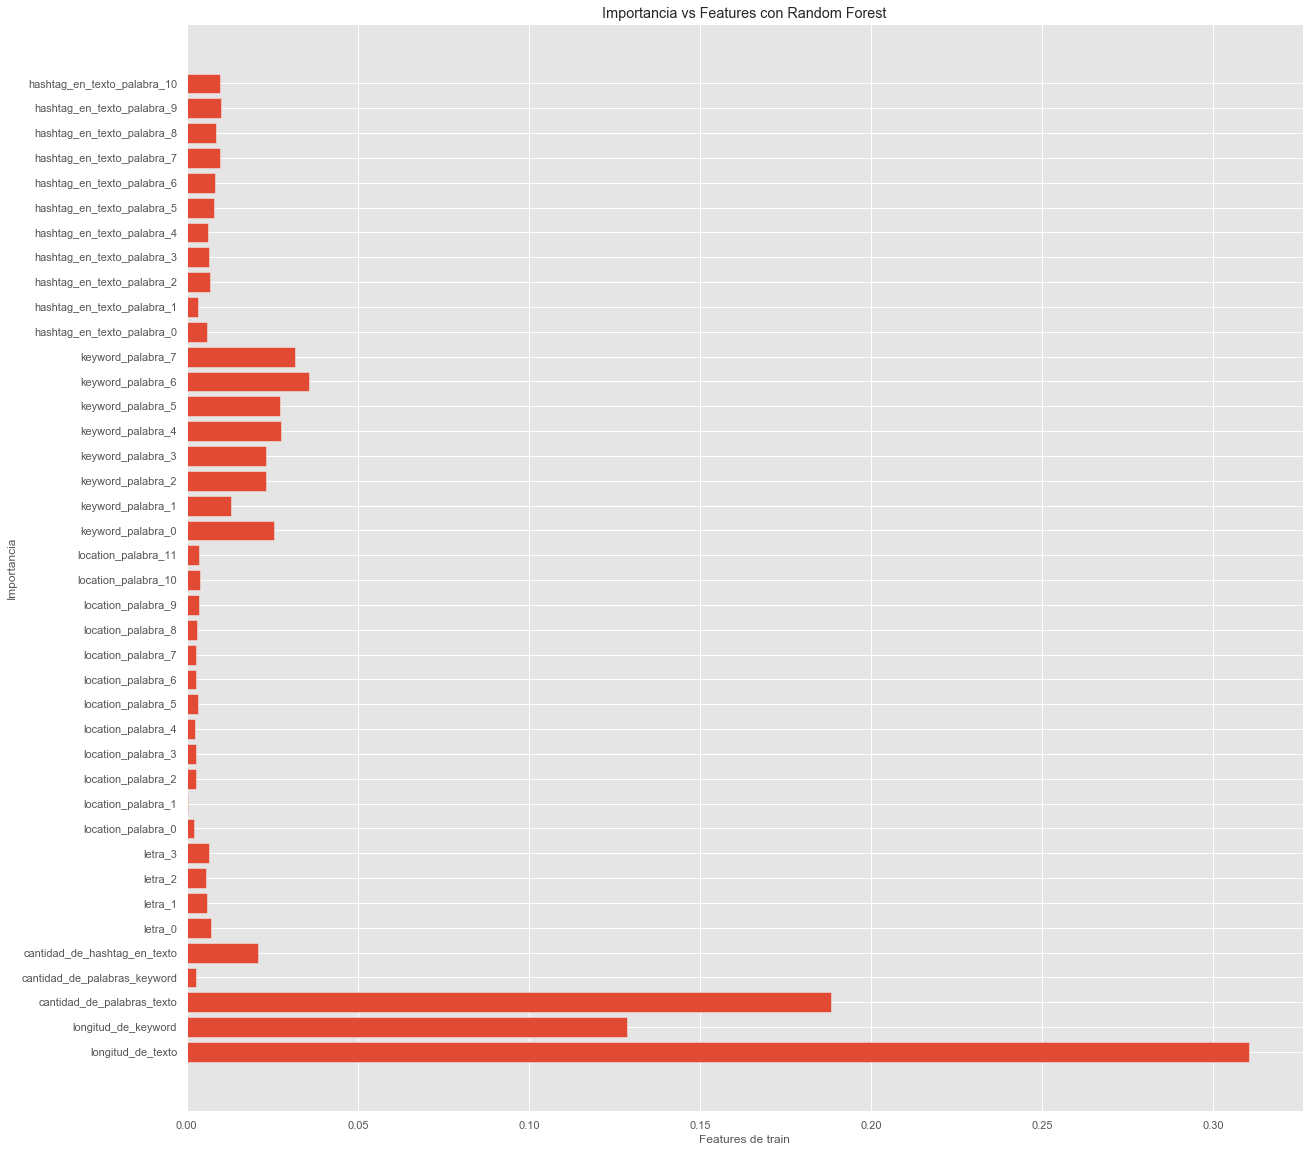

In [126]:
plt.barh(train_set.columns, rf.feature_importances_)
plt.xlabel('Features de train')
plt.ylabel('Importancia')
plt.title('Importancia vs Features con Random Forest')
plt.show()

In [99]:
importancia = rf.feature_importances_
cols = test_set.columns
for i in range(len(cols)):
    if (importancia[i] < 0.003):
        continue
    print(importancia[i],cols[i])

0.3092270364875148 longitud_de_texto
0.11316473763771981 longitud_de_keyword
0.18673304598048027 cantidad_de_palabras_texto
0.016159899895043576 cantidad_de_hashtag_en_texto
0.0033919761821855 letra_1
0.0030613864862297393 letra_3
0.0032112224182651115 location_palabra_6
0.00340815250994849 location_palabra_8
0.00373345183731902 location_palabra_10
0.021387914603093347 keyword_palabra_0
0.008857540705880707 keyword_palabra_1
0.019159597635675506 keyword_palabra_2
0.01533666221733747 keyword_palabra_3
0.023107127493745175 keyword_palabra_4
0.021643127169877405 keyword_palabra_5
0.031019662535900064 keyword_palabra_6
0.027894821773438987 keyword_palabra_7


## ENTREGA

In [31]:
resultado_final = result#varia segun el metodo
#resultado_final.columns = ['id','target']
#resultado_final.reset_index()
resultado_final.head()

,target
id,
0,0.00
2,1.00
3,1.00
9,0.00
11,1.00


In [32]:
#cuando todo termina el archivo de entrega
resultado_final.to_csv('submit.csv', index=False)